In [1]:
import math
import numpy as np

In [2]:
class Value:
    """
    Class of scalar values, which implements the following functionality:
    - composition of multiple Value class objects;
    - operations on Value class objects;
    - backpropagation algorithm for "chain rule";
    """
    def __init__(self, value, label='', children=()):
        self._value = value
        self._label = label
        self._grad = 0
        self._children = set(children) # Set of children of the expression
        self._backward = lambda: None  # Unique backpropagation function for each operation
        self._forward = lambda: None   # Unique forward propagation function for each operation

    def __repr__(self):
        children = [child._label for child in self._children]
        return f'Value( {self._label} = {self._value}; df/d[{self._label}] = {self._grad}; children = {children} )'
    
    
    # -------------------------------- Addition operators --------------------------------
    def __add__(self, other):
        if (not isinstance(other, Value)) and (isinstance(other, int) or isinstance(other, float)):
            other = Value(other, label=other)
        result = Value(
            self._value + other._value,
            f'({self._label} + {other._label})',
            children=(self, other)
        )

        def _backward():
            self._grad += result._grad
            other._grad += result._grad
            # print(self)
            # print(other)

        def _forward():
            result._value = self._value + other._value
            # print(self)
            # print(other)

        result._backward = _backward
        result._forward = _forward
        return result

    def __radd__(self, other: int):
        return self + other


    # -------------------------------- Multiplication operators --------------------------
    def __mul__(self, other):
        if (not isinstance(other, Value)) and (isinstance(other, int) or isinstance(other, float)):
            other = Value(other, label=other)
        result = Value(
            self._value * other._value,
            f'{self._label} * {other._label}',
            children=(self, other)
        )

        def _backward():
            self._grad += other._value * result._grad
            other._grad += self._value * result._grad
            # print(self)
            # print(other)

        def _forward():
            result._value = self._value * other._value
            # print(self)
            # print(other)

        result._backward = _backward
        result._forward = _forward
        return result

    def __rmul__(self, other: int):
        return self * other


    # -------------------------------- Exponential operator ------------------------------
    # def __pow__(self, other: int):
    #     """
    #     Implemets operation x**k, where k is an integer
    #     """
    #     children_ = self._children.copy()
    #     children_.add(self)

    #     result = Value(
    #         self._value ** other,
    #         f'{self._label}**{other}',
    #         children=children_
    #     )

    #     def _backward():
    #         self._grad += (other * self**(other-1) * result._grad)._value
    #         # print(self)
    #         # print(other)

    #     def _forward():
    #         result._value = self._value ** other
    #         # print(self)
    #         # print(other)

    #     result._backward = _backward
    #     result._forward = _forward
    #     return result

    def __pow__(self, other):
        if (not isinstance(other, Value)) and (isinstance(other, int) or isinstance(other, float)):
            other = Value(other, label=other)
    
        result = Value(
            self._value ** other._value,
            f'{self._label}**{other._label}',
            children=(self, other)
        )

        def _backward():
            try:
                int(self._label)
            except ValueError:
                self._grad += other._value * self._value**(other._value-1) * result._grad
            try:
                int(other._label)
            except ValueError:
                other._grad += result._value * math.log(self._value) * result._grad
            # print(self)
            # print(other)

        def _forward():
            result._value = self._value ** other._value
            # print(self)
            # print(other)

        result._backward = _backward
        result._forward = _forward
        return result

    def __rpow__(self, other: float):
        if (not isinstance(other, Value)) and (isinstance(other, int) or isinstance(other, float)):
            other = Value(other, label=other)
        return other**self


    # -------------------------------- Unary operators -----------------------------------
    def __pos__(self):
        return self

    def __neg__(self):
        result = self * (-1)
        result._label = f'{result._label}'
        return result


    # -------------------------------- Subtraction operators -----------------------------
    def __sub__(self, other):
        return self + (-other)

    def __rsub__(self, other: int):
        return (-self) + other


    # -------------------------------- Division operators --------------------------------
    def __truediv__(self, other):
        result = self * other**(-1)
        result._label = f'{self._label} / {other._label}'
        return result

    def __rtruediv__(self, other: int):
        result = self**(-1) * other
        result._label = f'{other._label} / {self._label}'
        return result


    # -------------------------------- Basic functions -----------------------------------
    def exp(self):
        result = Value(
            math.exp(self._value),
            f'exp({self._label})',
            children=(self,)
        )

        def _backward():
            self._grad += result._value * result._grad
            # print(self)

        def _forward():
            result._value = math.exp(self._value)

        result._backward = _backward
        return result


    def ln(self):
        result = Value(
            math.log(self._value),
            f'log({self._label})',
            children=(self,)
        )

        def _backward():
            self._grad += (1 / self._value) * result._grad
            # print(self)

        def _forward():
            result._value = math.log(self._value)

        result._backward = _backward
        return result


    # -------------------------------- Activation functions ------------------------------
    def sigmoid(self):
        sigmoid_ = 1 / (1 + math.exp(-self._value))
        result = Value(
            sigmoid_,
            f'σ({self._label})',
            children=(self,)
        )

        def _backward():
            self._grad += sigmoid_ * (1 - sigmoid_) * result._grad
            # print(self)
        
        def _forward():
            result._value = 1 / (1 + math.exp(-self._value))

        result._backward = _backward
        return result

    def softplus(self):
        result = Value(
            math.log(1 + math.exp(self._value)),
            f'softplus({self._label})',
            children=(self,)
        )

        def _backward():
            self._grad += (self.sigmoid() * result._grad)._value
            # print(self)

        def _forward():
            result._value = math.log(1 + math.exp(self._value))

        result._backward = _backward
        return result

    def swish(self, beta=1):
        swish_ = (self * (beta*self).sigmoid())._value
        result = Value(
            swish_,
            f'swish({self._label})',
            children=(self,)
        )

        def _backward():
            self._grad += (beta*(beta*self).swish()._value + (beta*self).sigmoid()._value * (1-beta*(beta*self).swish()._value) * result._grad)
            # print(self)

        def _forward():
            result._value = (self * (beta*self).sigmoid())._value

        result._backward = _backward
        return result


    # -------------------------------- Back and forward propagation ----------------------
    def backward(self):
        """
        Auto backpropagation
        """
        ordered_nodes = topological_sort(self)

        # Resetting gradients
        for node in ordered_nodes:
            node._grad = 0
        
        self._grad = 1
        for node in ordered_nodes:
            node._backward()

    def forward(self):
        """
        Auto forward propagation
        """
        ordered_nodes = topological_sort(self)[::-1]

        for node in ordered_nodes:
            node._forward()


# ----------------------------------------------------------------------------------------
#                              Sorting and optimization algorithms
# ----------------------------------------------------------------------------------------

def topological_sort(tree: Value):
    """
    Topological sorting algorithm with DFS (depth-first search)
    """
    visiting = [] # Nodes which were visited recently during first forward pass (to prevent cycling)
    visited = []  # Nodes which were visited with all their children included (during backward pass)

    def visit(node):
        if not (node in visiting or node in visited):
            visiting.append(node)
            for child in node._children:
                visit(child)
            visited.append(node)
            visiting.pop()
        order = visited[::-1]
        return order

    return visit(tree)

In [3]:
m = Value(3, 'm')
n = Value(2, 'n')
x = m*n; x._label='x'

f = x.exp()
print(f)

Value( exp(x) = 403.4287934927351; df/d[exp(x)] = 0; children = ['x'] )


In [4]:
f.backward()

In [5]:
f

Value( exp(x) = 403.4287934927351; df/d[exp(x)] = 1; children = ['x'] )

In [6]:
x

Value( x = 6; df/d[x] = 403.4287934927351; children = ['m', 'n'] )

In [7]:
g = math.e ** x

In [8]:
g

Value( 2.718281828459045**x = 403.428793492735; df/d[2.718281828459045**x] = 0; children = [2.718281828459045, 'x'] )

In [9]:
g.backward()

In [10]:
g

Value( 2.718281828459045**x = 403.428793492735; df/d[2.718281828459045**x] = 1; children = [2.718281828459045, 'x'] )

In [11]:
x

Value( x = 6; df/d[x] = 403.428793492735; children = ['m', 'n'] )

In [12]:
h = x ** math.e

In [13]:
h

Value( x**2.718281828459045 = 130.3870332357456; df/d[x**2.718281828459045] = 0; children = [2.718281828459045, 'x'] )

In [14]:
h.backward()

In [15]:
h

Value( x**2.718281828459045 = 130.3870332357456; df/d[x**2.718281828459045] = 1; children = [2.718281828459045, 'x'] )

In [16]:
x

Value( x = 6; df/d[x] = 59.07145051856881; children = ['m', 'n'] )

## **Manual backpropagation**

In [17]:
a = Value(2, 'a')
b = Value(-3, 'b')
e = a * b; e._label = 'e'
c = Value(10, 'c')
d = e + c; d._label = 'd'
f = Value(-2, 'f')
L = d * f; L._label = 'L'

print(L)

Value( L = -8; df/d[L] = 0; children = ['d', 'f'] )


In [18]:
L._grad = 1

In [19]:
L

Value( L = -8; df/d[L] = 1; children = ['d', 'f'] )

In [20]:
f

Value( f = -2; df/d[f] = 0; children = [] )

In [21]:
d

Value( d = 4; df/d[d] = 0; children = ['e', 'c'] )

In [22]:
L._backward()

In [23]:
f

Value( f = -2; df/d[f] = 4; children = [] )

In [24]:
d

Value( d = 4; df/d[d] = -2; children = ['e', 'c'] )

In [25]:
e

Value( e = -6; df/d[e] = 0; children = ['b', 'a'] )

In [26]:
c

Value( c = 10; df/d[c] = 0; children = [] )

In [27]:
d._backward()

In [28]:
a

Value( a = 2; df/d[a] = 0; children = [] )

In [29]:
b

Value( b = -3; df/d[b] = 0; children = [] )

In [30]:
e._backward()

## **1. Auto backpropagation**

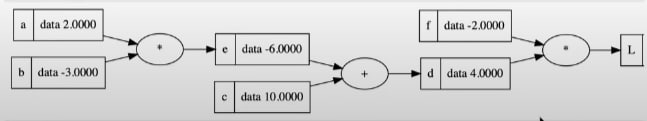

In [31]:
a = Value(2, 'a')
b = Value(-3, 'b')
e = a * b; e._label = 'e'
c = Value(10, 'c')
d = e + c; d._label = 'd'
f = Value(-2, 'f')
L = d * f; L._label = 'L'

L.backward()
print(L)

Value( L = -8; df/d[L] = 1; children = ['d', 'f'] )


In [32]:
nodes = topological_sort(L)
for node in nodes:
    print(node)

Value( L = -8; df/d[L] = 1; children = ['d', 'f'] )
Value( f = -2; df/d[f] = 4; children = [] )
Value( d = 4; df/d[d] = -2; children = ['e', 'c'] )
Value( c = 10; df/d[c] = -2; children = [] )
Value( e = -6; df/d[e] = -2; children = ['a', 'b'] )
Value( b = -3; df/d[b] = -4; children = [] )
Value( a = 2; df/d[a] = 6; children = [] )


In [33]:
x = Value(-2, 'x')
f = x*x; f._label = 'f'

f.backward()

nodes = topological_sort(f)
for node in nodes:
    print(node)

Value( f = 4; df/d[f] = 1; children = ['x'] )
Value( x = -2; df/d[x] = -4; children = [] )


## **2. Activation functions testing**

In [34]:
# Sigmoid test
x = Value(5, 'x')
sigmoid__ = x.sigmoid()
print(sigmoid__)
sigmoid__.backward()
print(x)

Value( σ(x) = 0.9933071490757153; df/d[σ(x)] = 0; children = ['x'] )
Value( x = 5; df/d[x] = 0.006648056670790033; children = [] )


In [35]:
# Softplus test
x = Value(5, 'x')
softplus__ = x.softplus()
print(softplus__)
softplus__.backward()
print(x)

Value( softplus(x) = 5.006715348489118; df/d[softplus(x)] = 0; children = ['x'] )
Value( x = 5; df/d[x] = 0.9933071490757153; children = [] )


In [36]:
# Swish test
x = Value(5, 'x')
swish__ = x.swish()
print(swish__)
swish__.backward()
print(x)

Value( swish(x) = 4.966535745378576; df/d[swish(x)] = 0; children = ['x'] )
Value( x = 5; df/d[x] = 1.0265474324296653; children = [] )


In [37]:
# Manual swish test
x = Value(5, 'x')
swish_manual = x * x.sigmoid()
print(swish_manual)
swish_manual.backward()
print(x)

Value( x * σ(x) = 4.966535745378576; df/d[x * σ(x)] = 0; children = ['σ(x)', 'x'] )
Value( x = 5; df/d[x] = 1.0265474324296655; children = [] )


## **Forward propagation test**

In [38]:
x = Value(-2, 'x')
f = x*x; f._label = 'f'

f.backward()
ordered_nodes = topological_sort(f)

# Old values
print()
for node in ordered_nodes:
    print(node)

# Little gradient descent
for node in ordered_nodes:
    try:
        label = int(node._label)
    except ValueError:
        node._value += -(1/4) * node._grad  # f(x)

# Updating values
f.forward()
f.backward()

# New values
print()
for node in ordered_nodes:
    print(node)


Value( f = 4; df/d[f] = 1; children = ['x'] )
Value( x = -2; df/d[x] = -4; children = [] )

Value( f = 1.0; df/d[f] = 1; children = ['x'] )
Value( x = -1.0; df/d[x] = -2.0; children = [] )


In [39]:
x = Value(-2, 'x')
f = x**2; f._label = 'f'

f.backward()
ordered_nodes = topological_sort(f)

# Old values
print()
for node in ordered_nodes:
    print(node)

# Little gradient descent
for node in ordered_nodes:
    try:
        label = int(node._label)
    except ValueError:
        node._value += -(1/4) * node._grad  # f(x)

# Updating values
f.forward()
f.backward()

# New values
print()
for node in ordered_nodes:
    print(node)


Value( f = 4; df/d[f] = 1; children = [2, 'x'] )
Value( x = -2; df/d[x] = -4; children = [] )
Value( 2 = 2; df/d[2] = 0; children = [] )

Value( f = 1.0; df/d[f] = 1; children = [2, 'x'] )
Value( x = -1.0; df/d[x] = -2.0; children = [] )
Value( 2 = 2; df/d[2] = 0; children = [] )


## **3. Gradient descent algorithms**

### **Default gradient descent algorithm**

In [40]:
def gradient_descent(function: Value, learning_rate=0.001, iter=100):
    """
    Gradient descent algorithm (default, with constant learning rate)
    """
    ordered_nodes = topological_sort(function)
    function.backward()

    for i in range(iter):
        for node in ordered_nodes:
            try:
                int(node._label)
            except ValueError:
                if not node._children:
                    node._value += -learning_rate * node._grad
        
        function.forward()
        function.backward()

### **Adam optimizer**

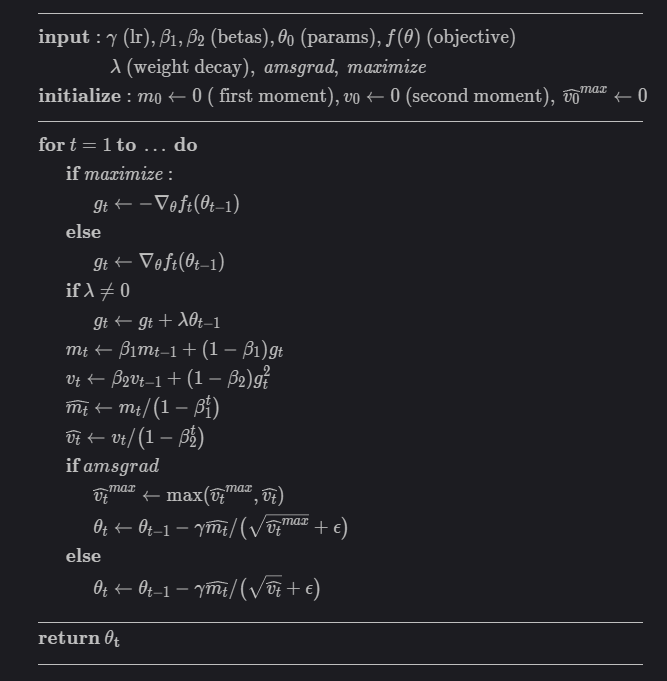

In [41]:
def adam_grad(function, learning_rate=0.001, b1=0.9, b2=0.999, eps=1e-8, iter=100):
    """
    Adaptive moment estimation algorithm (Adam)
    """
    params = topological_sort(function)
    n_params = len(params)
    leaves = [params[i] for i in range(n_params) if not params[i]._children]
    n_leaves = len(leaves)
    
    m = [0] * n_leaves
    v = [0] * n_leaves
    m_hat = [0] * n_leaves
    v_hat = [0] * n_leaves
    
    function.backward()

    for t in range(1, iter+1):
        function.backward()

        for i in range(n_leaves):
            m[i] = b1*m[i] + (1-b1)*leaves[i]._grad
            v[i] = b2*v[i] + (1-b2)*(leaves[i]._grad ** 2)
            m_hat[i] = m[i] / (1-b1**t)
            v_hat[i] = v[i] / (1-b2**t)
            
            try:
                label = int(leaves[i]._label)
            except ValueError:
                leaves[i]._value += -(learning_rate * m_hat[i]) / (v_hat[i]**0.5 + eps)
        
        function.forward()
        function.backward()

## **Algorithms testing**

---
### **Test 1**

#### Default GD

In [42]:
x1 = Value(2, label='x1')
x2 = Value(3, label='x2')
x3 = Value(4, label='x3')
f = x1**2 + 17*x2**2 + 35*x3**2; f._label='f'
print(f'f = {f._value}')

gradient_descent(f, learning_rate=0.01, iter=100)
print(f'f_min = {f._value}\n')
print(x1)
print(x2)
print(x3)

f = 717
f_min = 0.07035178642288623

Value( x1 = 0.2652391117895063; df/d[x1] = 0.5304782235790126; children = [] )
Value( x2 = 2.700939205452231e-18; df/d[x2] = 9.183193298537585e-17; children = [] )
Value( x3 = 2.061510082928032e-52; df/d[x3] = 1.4430570580496225e-50; children = [] )


#### Adam

In [43]:
x1 = Value(2, label='x1')
x2 = Value(3, label='x2')
x3 = Value(4, label='x3')
f = x1**2 + 17*x2**2 + 35*x3**2; f._label='f'
print(f'f = {f._value}')

adam_grad(f, learning_rate=0.1, b1=0.8, b2=0.9, iter=100)
print(f'f_min = {f._value}\n')
print(x1)
print(x2)
print(x3)

f = 717
f_min = 1.4807325242736403e-05

Value( x1 = 5.1669898226128956e-05; df/d[x1] = 0.00010333979645225791; children = [] )
Value( x2 = -0.00034309171257999535; df/d[x2] = -0.011665118227719842; children = [] )
Value( x3 = 0.0006048270772768845; df/d[x3] = 0.04233789540938192; children = [] )


---
### **Test 2**

#### Default GD

In [44]:
x = Value(-0.5, 'x')
f = (x-1)**2; f._label = 'f'; f._label='f'
print(f'f = {f._value}')

gradient_descent(f, learning_rate=0.01, iter=100)
print(f'f_min = {f._value}\n')

f = 2.25
f_min = 0.03957287986287359



In [45]:
f._value

0.03957287986287359

#### Adam

In [46]:
x = Value(-0.5, 'x')
f = (x-1)**2; f._label = 'f'; f._label='f'
print(f'f = {f._value}')

adam_grad(f, learning_rate=0.1, b1=0.8, b2=0.9, iter=100)
print(f'f_min = {f._value}\n')

f = 2.25
f_min = 2.495164720983636e-09



---
### **Test 3**

#### Default GD

In [47]:
x1 = Value(1, label='x1')
x2 = Value(1, label='x2')
f = x1**2 + 25*x2**2; f._label='f'
print(f'f = {f._value}')

gradient_descent(f, learning_rate=0.01, iter=100)
print(f'f_min = {f._value}\n')
print(x1)
print(x2)

f = 26
f_min = 0.017587946605721556

Value( x1 = 0.13261955589475316; df/d[x1] = 0.2652391117895063; children = [] )
Value( x2 = 7.888609052210118e-31; df/d[x2] = 3.944304526105059e-29; children = [] )


#### Adam

In [48]:
x1 = Value(1, label='x1')
x2 = Value(1, label='x2')
f = x1**2 + 25*x2**2; f._label='f'
print(f'f = {f._value}')

adam_grad(f, learning_rate=0.01, b1=0.7, b2=0.67, iter=100)
print(f'f_min = {f._value}\n')
print(x1)
print(x2)

f = 26
f_min = 6.400290133561407e-08

Value( x1 = -4.960199807398612e-05; df/d[x1] = -9.920399614797223e-05; children = [] )
Value( x2 = -4.961553914760268e-05; df/d[x2] = -0.002480776957380134; children = [] )


---
### **Test 4**

#### Default GD

In [49]:
x = Value(5, label='x')
f = 4 + (x-1)*(x+2) + 4; f._label='f'
print(f'f = {f._value}')

gradient_descent(f, learning_rate=0.1, iter=100)
print(f'f_min = {f._value}\n')
print(x)

f = 36
f_min = 5.75

Value( x = -0.49999999887963026; df/d[x] = 2.2407395938728314e-09; children = [] )


#### Adam

In [50]:
x = Value(5, label='x')
f = 4 + (x-1)*(x+2) + 4; f._label='f'
print(f'f = {f._value}')

adam_grad(f, learning_rate=0.1, b1=0.9, b2=0.999, iter=100)
print(f'f_min = {f._value}\n')
print(x)

f = 36
f_min = 5.7501615904048

Value( x = -0.4872881785412182; df/d[x] = 0.025423642917563605; children = [] )


---
### **Test 5**

#### Default GD

In [51]:
x = Value(5.59, label='x')
y = Value(5.59, label='y')
z = Value(5.59, label='z')
f = 4 + (x*y)**2 / z + 4; f._label='f'
print(f'f = {f._value}')

gradient_descent(f, learning_rate=0.1, iter=100)
print(f'f_min = {f._value}\n')
print(x)
print(y)
print(z)

f = 182.67687899999999
f_min = 8.002423764469658

Value( x = -0.3813211280753164; df/d[x] = -0.012712458299340732; children = [] )
Value( y = -0.3813211280753164; df/d[y] = -0.012712458299340732; children = [] )
Value( z = 8.72314440134343; df/d[z] = -0.0002778544476787791; children = [] )


#### Adam

In [52]:
x = Value(5.59, label='x')
y = Value(5.59, label='y')
z = Value(5.59, label='z')
f = 4 + (x*y)**2 / z + 4; f._label='f'
print(f'f = {f._value}')

adam_grad(f, learning_rate=0.1, b1=0.91, b2=0.9, iter=100)
print(f'f_min = {f._value}\n')
print(x)
print(y)
print(z)

f = 182.67687899999999
f_min = 8.000000082339422

Value( x = 0.03013629003553083; df/d[x] = 5.464469802225319e-06; children = [] )
Value( y = 0.03013629003553083; df/d[y] = 5.464469802225319e-06; children = [] )
Value( z = 10.017314896318714; df/d[z] = -8.219709999871332e-09; children = [] )


## Different tests

In [53]:
m, v, m_hat, v_hat = [[0]*2 for i in range(4)]

In [54]:
for elem in m, v, m_hat, v_hat:
    print(elem)

[0, 0]
[0, 0]
[0, 0]
[0, 0]


In [55]:
d = Value(2, 'd')
c = d + 1; c._label='c'
b = c * 2; b._label='b'
a = b + c; a._label='a'

parameters = topological_sort(a)

for param in parameters:
    if not str(param._label).isdigit():
        print(param)

Value( a = 9; df/d[a] = 0; children = ['c', 'b'] )
Value( b = 6; df/d[b] = 0; children = ['c', 2] )
Value( c = 3; df/d[c] = 0; children = ['d', 1] )
Value( d = 2; df/d[d] = 0; children = [] )
